<a href="https://colab.research.google.com/github/hardyjavier/cjmarquezr/blob/main/Copia_de_Lab02py_RegresionClasificacion_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analisis de vinos - Regresión y Clasificación

In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

%matplotlib inline

## Cargar el set de datos
Vamos a continuar usando el set de datos que limpiamos y transformamos en el [laboratorio pasado](./Lab01py_Preprocesamiento.ipynb) en donde se registran los atributos de varias botellas de vino junto con su calidad.  De esta forma usaremos el mismo dataset a lo largo de todo el flujo del curso como si se tratara de un proyecto real!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wine_df = pd.read_csv('/content/drive/MyDrive/winequality-white_clean.csv')
len(wine_df)

4461

In [ ]:
wine_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,score
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.15
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.67
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.48
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.74
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.45


## 2a. Regresión  
Ya hemos visto los conceptos básicos de una regresión:
- Aprendizaje **supervisado**
- Predecir una variable **contínua**
- Se busca encontrar los **pesos** de las variables para validar cada una de ellas cómo influye en nuestra variable final  

Lo primero que debemos hacer es separar nuestra variable objetivo (*score*) de las variables predictivas (En este caso son todas las demás)

In [ ]:
y = wine_df['score']
x = wine_df.drop(['score'], axis=1)
x.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


El siguiente paso, imprescindible en un proyecto de Machine Learning, es separar el dataset en dos, una porción para entrenar (70%) y una porción para probar (30%).  Estos porcentajes son sugeridos pero pueden variar.  Es importante que siempre el dataset de entrenamiento sea más grande que el de pruebas.

In [ ]:
print('Población:'+str(len(x)))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print('Muestra para Entrenamiento:'+str(len(x_train)))
print('Muestra para Pruebas:'+str(len(x_test)))

Población:4461
Muestra para Entrenamiento:3122
Muestra para Pruebas:1339


Ahora sí, vamos a ver qué tipos de modelos podemos entrenar con el dataset ya cargado y separado:

### OLS (Ordinary Least Squares)

Llamado así porque busca los coeficientes de la ecuación que minimizen la suma de las distancias verticales entre los datos y el modelo.  Para aplicar este modelo se debe validar que no haya multicolinealidad entre las variables predictivas, pues no la detecta fácilmente.  
![OLS](https://miro.medium.com/max/3268/1*AwC1WRm7jtldUcNMJTWmiA.png)

- **Precisión:** Alta, para variables no correlacionadas (Condiciones para OLS [aquí](https://statisticsbyjim.com/regression/ols-linear-regression-assumptions))
- **Velocidad:** Rápido
- **Explicativo:** Mucho (Peso/Importancia de cada variable)
- **Sensible a cambios:** Poco, OLS crea una estimación generalizada a todos los puntos, un solo valor atípico modificará los pesos de las variables pero no drasticamente, pues seguirá convergiendo a los demás puntos
- **Deteminístico**: Sí

In [ ]:
x.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

En el parámetro para *smf.ols()* se le indica al modelo que necesitamos una función de la forma:
> Y ~ X1 + X2 + X3 + X4 + ... + Xn  

En donde Y es nuestra variale objetivo y cada Xi son las variables predictivas para las que se debe buscar un peso en la ecuación.

In [ ]:
model_ols = smf.ols('score ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar +\
              chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH+\
              sulphates + alcohol', data=wine_df)
fit_ols = model_ols.fit()
fit_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     152.1
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          2.30e-298
Time:                        16:04:46   Log-Likelihood:                -5301.4
No. Observations:                4461   AIC:                         1.063e+04
Df Residuals:                    4449   BIC:                         1.070e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              153.5215     20.503      7.488      0.000     113.324     193.718
fixed_acidity            0.1088      0.024      4.611      0.000       0.063       0.155
volatile_acidity        -1.6731      0.127    -13.209      0.000      -1.921      -1.425
citric_acid              0.1496      0.109      1.371      0.170      -0.064       0.363
residual_sugar           0.0813      0.008      9.843      0.000       0.065       0.097
chlorides               -0.5376      0.637     -0.844      0.399      -1.786       0.711
free_sulfur_dioxide      0.0043      0.001      4.517      0.000       0.002       0.006
total_sulfur_dioxide    -0.0006      0.000     -1.494      0.135      -0.001       0.000
density               -154.2728     20.814     -7.412      0.000    -195.078    -113.467
pH                       0.8969      0.125      7.200      0.000       0.653       1.141
sulphates                0.6693      0.111      6.008      0.000       0.451       0.888
alcohol                  0.2012      0.026      7.620      0.000       0.149       0.253
==============================================================================
Omnibus:                       62.094   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.404
Skew:                          -0.005   Prob(JB):                     1.44e-25
Kurtosis:                       3.784   Cond. No.                     3.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

La funcion *fit.summary()* nos entrega un montón de información, vamos a analizar la que más nos interesa:  

- Modelo utilizado (OLS), cantidad de registros y de variables usadas (incluyendo intercepto)
- Df Residuals (Flexibilidad del modelo: #Observacionnes - #Variables) y Df modelo (#Variables -Intercepto) *(Un dato que no da el summary de R)*
- R2, en la primera tabla, es el cuadrado del coeficiente de correlación de todas las variables y representa el porcentaje estimado de varianza que puede ser explicado por el modelo.  
- Adj. R2 es un R2 que penaliza coeficientes muy grandes o muy bajos y variables redundantes.  
- La tabla del centro nos muestra los coeficientes encontrados por el modelo para cada variable, junto con el error estándar de cada uno.  Esto significa que nuestro modelo tiene la forma:

$$
y = 153.5215 + 0.1088(fixed acidity) - 1.6731(volatile acidity) + ... + 0.2012(alcohol)
$$

- Los valores t y valores P (*P>t*), para cada variable, indican si esta afecta o no la variable objetivo.  Son valores estadísticos, por lo general se busca que P < 0.05
- Intervalo de confianza de cada variable [0.025 - 0.975]

Por ahora, vamos a trabajar con estos valores para mejorar nuestro modelo.  Si quieres saber en detalle el significado y el impacto de modificar cada uno de estos resultados, puedes leer más [aquí](https://www.datarobot.com/blog/ordinary-least-squares-in-python/)

**Taller**  
Juegue un poco con las variables en la función *smf.ols()* para ver si logra aumentar el R2 del modelo.  Por ejemplo:
- Revise las variables que, según el  [laboratorio pasado](./Lab01py_Preprocesamiento.ipynb) están correlacionadas entre sí y aquellas que están correlacionadas con la variabe objetivo
- Revise las variables que, según el modelo afectan la variable objetivo (*P valores*)  

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [ ]:
fit_ols.save('/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_ols.pkl')

In [ ]:
model_ols = smf.ols('score ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar +\
              chlorides + total_sulfur_dioxide + pH+\
              sulphates + alcohol', data=wine_df)
fit_ols = model_ols.fit()
fit_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     172.8
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          1.07e-281
Time:                        16:04:46   Log-Likelihood:                -5345.3
No. Observations:                4461   AIC:                         1.071e+04
Df Residuals:                    4451   BIC:                         1.077e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.7825      0.411      4.334      0.000       0.976       2.589
fixed_acidity           -0.0290      0.017     -1.723      0.085      -0.062       0.004
volatile_acidity        -1.9481      0.124    -15.737      0.000      -2.191      -1.705
citric_acid              0.1008      0.110      0.917      0.359      -0.115       0.316
residual_sugar           0.0256      0.003      9.064      0.000       0.020       0.031
chlorides               -1.2917      0.635     -2.036      0.042      -2.536      -0.048
total_sulfur_dioxide     0.0002      0.000      0.507      0.612      -0.000       0.001
pH                       0.2976      0.100      2.984      0.003       0.102       0.493
sulphates                0.4386      0.108      4.046      0.000       0.226       0.651
alcohol                  0.3800      0.012     30.476      0.000       0.356       0.404
==============================================================================
Omnibus:                       54.253   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.201
Skew:                          -0.016   Prob(JB):                     2.13e-21
Kurtosis:                       3.715   Cond. No.                     7.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
fit_ols.save('/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_ols_1.pkl')

### Modelos Polinomiales  
Modelos como el anterior, en los que se define una *fórmula* para que el modelo encuentre los coeficientes, son muy comunes en las funciones de R.  
[scikit-learn](https://scikit-learn.org/dev/index.html), es la librería preferida de los que trabajamos con Machine Learning en **Python**.  No solo para predicción de variables contínuas sino para todo tipo de modelos.  
>Por ejemplo, el ejercicio anterior puede realizarse también con esta librería usando la clase *LinearRegression()*  

Para ello, es necesario dividir el dataset en entrenamiento y prueba y **diferenciar las variables predictivas (x) de la variable objetivo (y).**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
columnas = ['residual_sugar', 'alcohol', 'citric_acid']

x_train = x_train[columnas]
x_test = x_test[columnas]

In [ ]:
model_poly = PolynomialFeatures(degree=2)
x_train_poly = model_poly.fit_transform(x_train)
x_test_poly = model_poly.fit_transform(x_test)

model_linpoly = LinearRegression()
model_linpoly.fit(x_train_poly, y_train)
model_linpoly.feature_names_ = model_poly.get_feature_names()

model_linpoly.score(x_test_poly, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.23437825556359826

En celdas anteriores hemos dividido el conjunto de datos en dos subconjuntos: Entrenamiento y Prueba.  
Ahora, hemos tomado solo tres de ellas (*residual_sugar, alcohol, citric_acid*), para el ejemplo y creado y entrenado (*fit*) un modelo polinomial usando únicamente el set de entrenamiento, y hemos calculado el $R2$ (*score*) usando el set de pruebas: **23%**, el modelo aún puede mejorar, esto lo haremos más adelante.  
Pero cuál es este modelo/ecuación qué hemos creado, asi como lo vimos en la sección pasada?

In [ ]:
print(model_linpoly.coef_)
print('Cantidad de coeficientes: ' + str(len(model_linpoly.coef_)))

[ 0.00000000e+00  1.06650064e-01  6.45477565e-01  2.47922588e+00
 -9.56781899e-04 -5.60730321e-03 -3.78017361e-02 -1.06736019e-02
 -5.00653324e-02 -1.75114094e+00]
Cantidad de coeficientes: 10


Parecen ser muchos? Porqué? Cómo saber a qué variable corresponde cada uno?

In [ ]:
' + '.join(['('+str(c)+')*'+f for c,f in
          zip(model_linpoly.coef_, model_linpoly.feature_names_)])

'(0.0)*1 + (0.10665006370762502)*x0 + (0.6454775653273184)*x1 + (2.479225879607156)*x2 + (-0.0009567818991779997)*x0^2 + (-0.0056073032054227145)*x0 x1 + (-0.03780173605013891)*x0 x2 + (-0.010673601861557984)*x1^2 + (-0.05006533237909562)*x1 x2 + (-1.751140944605882)*x2^2'

En este formato $X0, X1 y X2$ corresponden a nuestras columnas elegidas para el ejemplo: *residual_sugar, alcohol, citric_acid*  

Pero no es necesario realizar este calculo cada vez que queramos predecir un dato nuevo. El modelo nos entrega predicciones de un nuevo set de datos usando la función *predict*

In [ ]:
print(model_linpoly.predict(x_test_poly))

[6.46198484 6.02779122 6.2357096  ... 5.731812   5.92737537 6.61237207]


**Taller**  
Juegue un poco con las variables a incluir o no en el modelo, así como el grado de la regresión polinomial para ver si logra aumentar el score del modelo.

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_poly.pkl", "wb") as f:
    pickle.dump(model_linpoly, f)

## segundo modelo polinomio
1. se cambia el graado del pol
2. se cambian las columnas de los  datos

##1

In [ ]:
model_poly_1 = PolynomialFeatures(degree=3)
x_train_poly = model_poly_1.fit_transform(x_train)
x_test_poly = model_poly_1.fit_transform(x_test)

model_linpoly_1 = LinearRegression()
model_linpoly_1.fit(x_train_poly, y_train)
model_linpoly_1.feature_names_ = model_poly_1.get_feature_names()

model_linpoly_1.score(x_test_poly, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


-0.3191370413489376

In [ ]:
print(model_linpoly_1.coef_)
print('Cantidad de coeficientes: ' + str(len(model_linpoly_1.coef_)))

[ 0.00000000e+00  3.67899826e-01 -2.73389549e+00  7.44377423e+00
  1.69184278e-02 -7.17428608e-02 -4.25558299e-01  3.13645266e-01
 -6.39543039e-02 -8.89235892e+00 -9.36273417e-05 -1.67117124e-03
  3.92784537e-03  3.99541969e-03  2.82320057e-02  6.92278350e-02
 -1.02103419e-02 -1.56394923e-02  7.25384020e-02  3.31318214e+00]
Cantidad de coeficientes: 20


In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_poly_1.pkl", "wb") as f:
    pickle.dump(model_linpoly_1, f)

##2

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
columnas_1 = ['residual_sugar', 'alcohol', 'citric_acid','volatile_acidity','citric_acid']

x_train_1 = x_train[columnas_1]
x_test_1 = x_test[columnas_1]
x_test_1

,residual_sugar,alcohol,citric_acid,volatile_acidity,citric_acid
297,9.3,10.4,0.44,0.28,0.44
969,6.0,9.7,0.24,0.47,0.24
3814,6.5,10.2,0.24,0.20,0.24
598,14.4,9.1,0.34,0.26,0.34
3673,1.0,9.5,0.57,0.29,0.57
...,...,...,...,...,...
2057,6.1,9.7,0.38,0.23,0.38
1088,0.8,9.5,0.27,0.45,0.27
479,1.6,9.1,0.37,0.18,0.37
727,13.7,9.0,0.19,0.23,0.19


In [ ]:
model_poly_2 = PolynomialFeatures(degree=2)
x_train_poly = model_poly_2.fit_transform(x_train_1)
x_test_poly = model_poly_2.fit_transform(x_test_1)

model_linpoly_2 = LinearRegression()
model_linpoly_2.fit(x_train_poly, y_train)
model_linpoly_2.feature_names_ = model_poly_2.get_feature_names()

model_linpoly_2.score(x_test_poly, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.2720378421780657

In [ ]:
print(model_linpoly_2.coef_)
print('Cantidad de coeficientes: ' + str(len(model_linpoly_2.coef_)))

[ 0.00000000e+00  7.53167773e-02 -3.27642909e-02  4.64023815e-01
 -9.68388398e+00  4.64023815e-01 -1.80088679e-03 -3.83005336e-03
 -5.95866927e-03  7.18756923e-02 -5.95866927e-03  1.32204156e-02
 -4.22345253e-02  5.75178573e-01 -4.22345253e-02 -1.92367728e-01
  7.30657902e-01 -1.92367728e-01  8.35988067e-01  7.30657902e-01
 -1.92367728e-01]
Cantidad de coeficientes: 21


In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_poly_2.pkl", "wb") as f:
    pickle.dump(model_linpoly_2, f)

## 2b. Clasificación  
Ya hemos visto porqué una regresión lineal es diferente a una clasificación, tanto en el concepto como matemáticamente:
- Predecir una variable **categórica**
- Se busca encontrar los patrones o similitudes entre cada *clase* para poder clasificar después un registro nuevo  

Sin embargo, al igual que en la Regresión, lo primero que debemos hacer es separar nuestra variable objetivo (*high_quality*) de las variables predictivas

In [ ]:
wine_df = pd.read_csv('/content/drive/MyDrive/2. Materiales y evidencias (1)/Aprendizaje Automático/data/winequality-red_clean.csv')
len(wine_df)

1571

In [ ]:
y = wine_df['high_quality']
x = wine_df.drop(['high_quality'], axis=1)
x.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Regresion Logística

Similar a una regresión lineal, busca definir el comportamiento de los datos a través de una **ecuación**, con la diferencia que en este caso estamos buscando una variable categórica (1/0 o SI/NO), por lo que no nos serviría una ecuación que retorne un valor entre $(-\infty, \infty)$.  
Sin embago, al ser una ecuación, asume que los datos son linealmente separables:

![Logit](https://qph.fs.quoracdn.net/main-qimg-4ddda954955cabf0fb59364cc37232b7.webp)

- **Precisión:** Alta, para variables no correlacionadas y modelos linealmente separables
- **Velocidad:** Rápido
- **Explicativo:** Mucho (Peso/Importancia de cada variable)
- **Sensible a cambios:** Mucho, asume que los datos son separables linealmente
- **Deteminístico**: No, probabilístico

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
model_log = LogisticRegression(solver='liblinear')
model_log.fit(x_train, y_train)
print('Score: {}'.format(model_log.score(x_test, y_test)))

Score: 0.7428571428571429


Nuevamente hemos entrenado el modelo con los datos de entrenamiento y calculamos el error con datos de prueba, aunque no parece un score tan malo, veamos cómo se comporta el modelo:

In [ ]:
model_log.predict_proba(x_test)

array([[0.75588046, 0.24411954],
       [0.72383716, 0.27616284],
       [0.07711102, 0.92288898],
       [0.61991621, 0.38008379],
       [0.50672766, 0.49327234],
       [0.66317948, 0.33682052],
       [0.81071664, 0.18928336],
       [0.57501468, 0.42498532],
       [0.68301286, 0.31698714],
       [0.79591488, 0.20408512],
       [0.48600368, 0.51399632],
       [0.20497592, 0.79502408],
       [0.72262763, 0.27737237],
       [0.13208678, 0.86791322],
       [0.85476631, 0.14523369],
       [0.19953157, 0.80046843],
       [0.23882103, 0.76117897],
       [0.88076538, 0.11923462],
       [0.33251711, 0.66748289],
       [0.11661223, 0.88338777],
       [0.77295117, 0.22704883],
       [0.16632986, 0.83367014],
       [0.26724604, 0.73275396],
       [0.57259993, 0.42740007],
       [0.85692706, 0.14307294],
       [0.2836566 , 0.7163434 ],
       [0.58860739, 0.41139261],
       [0.10259215, 0.89740785],
       [0.26079696, 0.73920304],
       [0.32043262, 0.67956738],
       [0.

In [ ]:
y_pred = model_log.predict(x_test)
print('Ground Truth: '+str(np.array(y_test)[:20]))
print('Prediciones:  '+str(y_pred[:20]))

Ground Truth: [1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1]
Prediciones:  [0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1]


**Taller**  
Juegue un poco con las variables a incluir en el modelo para ver si logra aumentar el score del modelo y sus predicciones.  Algunas sugerencias:
- Valide qué variables permiten la separación lineal de los datos
- Puede incluir mas de dos variables para entrenar el modelo, es lo más recomendable, pero recuerde que no será posible visualizar la separación gráficamente
- Intente con el parámetro *solver* de la función LogisticRegression(), éste permite generar otro tipo de líneas que pueden mejorar el modelo (Los posibles valores para el parámetro solver son: *'liblinear', 'newton-cg', 'lbfgs', 'sag' y 'saga'*.  Para saber en detalle qué tipo de modelo genera cada uno puede consultar [aqui](https://medium.com/@venali/conventional-guide-to-supervised-learning-with-scikit-learn-logistic-regression-generalized-e9783c414588))

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_log.pkl", "wb") as f:
    pickle.dump(model_log, f)

## segundo modelo
cambiamos el metodo de solver = newton

In [ ]:
model_log_1 = LogisticRegression(solver='newton-cg')
model_log_1.fit(x_train, y_train)
print('Score: {}'.format(model_log.score(x_test, y_test)))

Score: 0.7428571428571429


In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_log_1.pkl", "wb") as f:
    pickle.dump(model_log, f)

## modelo 2
cambiando las variables

### Vecinos más cercanos (kNN)

Es un método de clasificación para problemas **no lineales**, y tal vez con una metodología/matemática más sencilla.
Consiste en ver los datos como puntos en un plano (de N dimensiones cuántas variables incluya el modelo) y clasificar cualquier "punto nuevo" en la misma clase a la que pertenescan los *k* puntos más cercanos (*k* puede ser definido por nosotros mismos)

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTIr4A7USCWANPP8HDtHIOmN2HOY_CK1PhL2Q&usqp=CAU" alt="kNN" width="400"/>

- **Precisión:** Depende intensamente del valor de k.  muy eficiente para datasets sin ruido
- **Velocidad:** Depende de dimensiones (*Realmente no construye ningún modelo*)
- **Explicativo:** Mucho (Es una ecuación sencilla)
- **Sensible a cambios:** Mucho a atributos irrelevantes y la complejidad del modelo
- **Deteminístico**: Sí

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=18)
model_knn.fit(preprocessing.normalize(x_train), y_train)
print('Score: {}'.format(model_knn.score(x_test, y_test)))

Score: 0.6571428571428571


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


En este caso, se eligió el número de vecinos (k) aleatoriamente, y con razón no obtuvimos un score bueno. Pero cuidado:
- Si k es muy pequeño, tendiendo a 1, el modelo va a decidir por la clase del ejemplo más cercano. Esto hace el modelo muy sensible al ruido o a pequeños cambios.
- Si k es muy grande, tendiendo a N, el modelo no podrá generalizar.  Nunca analizará patrones, reglas, ni similitudes sino que decidirá siempre *lo que diga la mayoría*  

**Taller**  
Juegue un poco con el valor de k (*n_neighbors* en la función *KNeighborsClassifier*) para mejorar el score del modelo.  
También puede intentar eliminando aquellas variables que generen ruido o atípicos sobre los datos.

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_knn.pkl", "wb") as f:
    pickle.dump(model_knn, f)

In [ ]:
model_knn_1 = KNeighborsClassifier(n_neighbors=180)
model_knn_1.fit(preprocessing.normalize(x_train), y_train)
print('Score: {}'.format(model_knn.score(x_test, y_test)))

Score: 0.6571428571428571


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_knn_1.pkl", "wb") as f:
    pickle.dump(model_knn, f)

### Máquinas de Soporte Vectorial (SVM)

Cuando hablamos de Regresión logística, buscamos **una línea** que divida los datos de la mejor manera. Pero, qué pasa cuando hay más de una línea que cumple con esta condición? Cómo elegir la mejor?  
Las maquinas de soporte vectorial buscan, por el contrario, un *hiperplano*: un conjunto de líneas que maximicen la distancia/margen entre los puntos más cercanos de cada clase.  A estos puntos más cercanos se les conoce como *vectores de soporte*

<img src="https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2017/08/how-svm-works.png" alt="SVM" width="400"/>

- **Precisión:** Alta si se configura correctamente
- **Velocidad:** Lento para una gran cantidad de datos
- **Explicativo:** No
- **Sensible a cambios:** Si, sobretodo a ejemplos mal etiquetados
- **Deteminístico**: Sí

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
model_svm = svm.SVC(probability= True,
                    kernel='rbf')
model_svm.fit(x_train, y_train)
print('Score: {}'.format(model_svm.score(x_test, y_test)))

Score: 0.6285714285714286


Aún tenemos un error un poco alto.  Sin embargo, una de las ventajas de SVM, a pesar de ser un algoritmo lento y sensible al ruido, es su versatilidad para manejar problemas no lineales.  Esto lo logra por medio del parámetro **kernell** que permite definir "la forma" del/los hiperplano/s que va a generar:  
![Kernell](https://i.imgur.com/HKTLn35.png)

**Taller**  
Juegue un poco con las columnas a incluir en el modelo, así como con el **kernell** de la función *svm.SVC()*.  Los posibles valores de este parámetro son:
- 'linear'
- 'poly' (Polinomial, en este caso tambien se puede configurar el parámetro *degree*)
- 'rbf'
- 'sigmoid'

Puede que encuentre varios modelos que le parezcan convenientes.  Se sugiere guardar cada uno de la siguiente manera (cambiando el nombre del archivo):

In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_svm.pkl", "wb") as f:
    pickle.dump(model_svm, f)

## SEGUNDO MODELO

In [ ]:
model_svm = svm.SVC(probability= True,
                    kernel='sigmoid')
model_svm.fit(x_train, y_train)
print('Score: {}'.format(model_svm.score(x_test, y_test)))

Score: 0.6095238095238096


In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_svm_2.pkl", "wb") as f:
    pickle.dump(model_svm, f)

### Árboles de Decisión

Es el tipo de algoritmo más fácil de entender, pues se basa en reglas condicionales muy similares al lenguaje humano (*Si... entonces...*).  El entrenamiento consiste en encontrar las reglas y condiciones que cubran la mayor cantidad de casos.  
El modelo gráficamente puede ser representado mediante un árbol en el que los **nodos intermedios** son decisiones basadas en alguno de los atributos predictivos, y las **hojas** son la clase objetivo.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png" alt="Decision Tree" width="400"/>

- **Precisión:** Alta tendencia al sobreajuste (memorizar datos)
- **Velocidad:** Rápido. La validación de reglas son condicionales
- **Explicativo:** Sí
- **Sensible a cambios:** Si, pequeños cambios en los datos puede resultar en árboles completamente diferentes.
- **Deteminístico**: No

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
650,6.9,0.40,0.24,2.5,0.083,30.0,45.0,0.99590,3.26,0.58,10.0
1313,7.5,0.51,0.02,1.7,0.084,13.0,31.0,0.99538,3.36,0.54,10.5
1513,7.4,0.25,0.29,2.2,0.054,19.0,49.0,0.99666,3.40,0.76,10.9
381,7.4,0.63,0.07,2.4,0.090,11.0,37.0,0.99790,3.43,0.76,9.7
1088,8.9,0.24,0.39,1.6,0.074,3.0,10.0,0.99698,3.12,0.59,9.5


In [ ]:
model_tree= DecisionTreeClassifier(max_depth=3)
model_tree.fit(x_train, y_train)
print('Score: {}'.format(model_tree.score(x_test, y_test)))

Score: 0.6984126984126984


En cada uno de los nodos, el algoritmo valida qué variable y qué valor de esa variable produce un nivel mayor de "pureza" entre las hojas (*Entropía/gini index*).  Si este nivel no es suficiente para dar una buena decisión, se hace una nueva partición en cada una de las hojas, validando nuevamente todas las variables predictivas.  
Por esto mismo, los árboles de decisión tienen varios parámetros que configurar (Nivel mínimo de entropía, profundidad máxima del árbol, mínima cantidad de muestras para las hojas, etc.)  
Otra de las ventajas de los árboles es que son **tan explicativos**, que pueden ser graficados para validar el proceso de toma de cada decisión en el proceso de predicción:

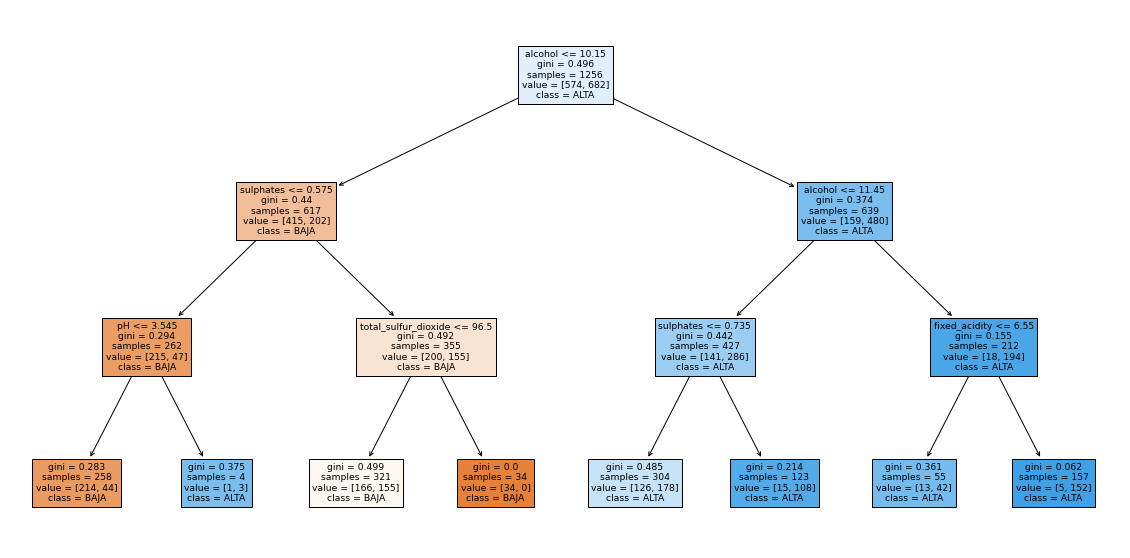

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(model_tree,
               feature_names=x.columns,
               class_names=['BAJA', 'ALTA'],
               filled=True);

**Taller**  
Juegue un poco con las columas a incluir en el modelo, así como con los parámetros de la función *DecisionTreeClassifier()*, como por ejemplo: *max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, ...*

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_tree.pkl", "wb") as f:
    pickle.dump(model_tree, f)

### Ensambles de Modelos
Cuando un modelo es **no determinístico**, pero tiende al **sobreajuste**, es decir, aprende de memoria las reglas y patrones del set de entrenamiento, hasta el punto de no predecir correctamente sobre el test de pruebas, esto puede solucionarse haciendo un ensamble o conjunto de modelos.  Esto es, construir varios modelos "débiles" y crear uno "robusto", tomando la decisión final dependiendo de:
- "Democracia", el resultado es lo que diga la mayoría de modelos, realizando cada uno **bajo un set de entrenamiento diferente** (*BaggingClassifier*)
- "Aleatorio", el resultado es lo que diga la mayoría de árboles de decisión, realizando cada uno con un set aleatorio de  variables (*RandomForestClassifier*)

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780128177365000090-f09-17-9780128177365.jpg" alt="Rnd Forest" width="500"/>

- **Precisión:** Alta, varios modelos eliminan el sobreajuste
- **Velocidad:** Lento, por presición se sacrifica velocidad
- **Explicativo:** Sí, aunque no entrega el modelo, entrega importancia de variables
- **Sensible a cambios:** No mucho, un dato atípico puede modificar un arbol, pero no todos
- **Deteminístico**: No

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
model_forest= RandomForestClassifier(n_estimators=20, max_depth=5)
model_forest.fit(x_train, y_train)
print('Score: {}'.format(model_forest.score(x_test, y_test)))

Score: 0.765079365079365


Note que, si la anterior celda se ejecuta varias veces, el resultado cada vez tendrá un valor diferente.  Esto significa que el modelo es **no determinístico**.  Aunque el score cambie con solo ejecutarlo, es mejor configurar algunos parámetros para indicarle al modelo por dónde está la mejor solución.  
El concenso realizado entre los modelos permite al algoritmo, a pesar de ser no determinístico, darse una idea de la importancia de cada variable en la toma de la decisión:

In [ ]:
for col, imp in zip(x.columns, model_forest.feature_importances_) :
    print('{}: {:.2f}'.format(col, imp))

fixed_acidity: 0.04
volatile_acidity: 0.12
citric_acid: 0.04
residual_sugar: 0.03
chlorides: 0.04
free_sulfur_dioxide: 0.02
total_sulfur_dioxide: 0.12
density: 0.06
pH: 0.02
sulphates: 0.16
alcohol: 0.34


**Taller**  
Juegue un poco con las columnas a incluir en el modelo, en este caso revise la importancia de variables.  
Puede también jugar con los parámetros de la función *RandomForestClassifier()*, que son los mismos del Árbol de Decisión con la adición de *n_estimators* (Cantidad de modelos/árboles a generar)

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_forest.pkl", "wb") as f:
    pickle.dump(model_forest, f)

In [ ]:
model_forest_1= RandomForestClassifier(n_estimators=20, max_depth=5,min_samples_split = 2)
model_forest_1.fit(x_train, y_train)
print('Score: {}'.format(model_forest_1.score(x_test, y_test)))

Score: 0.7619047619047619


In [ ]:
with open("/content/drive/MyDrive/CIENCIA_DATOS/modelos/model_forest_1.pkl", "wb") as f:
    pickle.dump(model_forest, f)